In [1]:
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, plot_confusion_matrix, classification_report
from scipy import stats

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
train.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


In [4]:
test.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,19556,Female,Loyal Customer,52,Business travel,Eco,160,5,4,...,5,5,5,5,2,5,5,50,44.0,satisfied
1,1,90035,Female,Loyal Customer,36,Business travel,Business,2863,1,1,...,4,4,4,4,3,4,5,0,0.0,satisfied
2,2,12360,Male,disloyal Customer,20,Business travel,Eco,192,2,0,...,2,4,1,3,2,2,2,0,0.0,neutral or dissatisfied
3,3,77959,Male,Loyal Customer,44,Business travel,Business,3377,0,0,...,1,1,1,1,3,1,4,0,6.0,satisfied
4,4,36875,Female,Loyal Customer,49,Business travel,Eco,1182,2,3,...,2,2,2,2,4,2,4,0,20.0,satisfied


In [5]:
def transform_gender(x):
    if x == 'Female':
        return 1
    elif x == 'Male':
        return 0
    else:
        return -1
    
def transform_customer_type(x):
    if x == 'Loyal Customer':
        return 1
    elif x == 'disloyal Customer':
        return 0
    else:
        return -1
def transform_travel_type(x):
    if x == 'Business travel':
        return 1
    elif x == 'Personal Travel':
        return 0
    else:
        return -1
    
def transform_class(x):
    if x == 'Business':
        return 2
    elif x == 'Eco Plus':
        return 1
    elif x == 'Eco':
        return 0    
    else:
        return -1
def transform_satisfaction(x):
    if x == 'satisfied':
        return 1
    elif x == 'neutral or dissatisfied':
        return 0
    else:
        return -1
    
def process_data(df):
    df = df.drop(['Unnamed: 0', 'id'], axis = 1)
    df['Gender'] = df['Gender'].apply(transform_gender)
    df['Customer Type'] = df['Customer Type'].apply(transform_customer_type)
    df['Type of Travel'] = df['Type of Travel'].apply(transform_travel_type)
    df['Class'] = df['Class'].apply(transform_class)
    df['satisfaction'] = df['satisfaction'].apply(transform_satisfaction)
    df['Arrival Delay in Minutes'].fillna(df['Arrival Delay in Minutes'].median(), inplace = True)
    
    return df

train = process_data(train)
test = process_data(test)


In [6]:
train.head()

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,1,13,0,1,460,3,4,3,1,...,5,4,3,4,4,5,5,25,18.0,0
1,0,0,25,1,2,235,3,2,3,3,...,1,1,5,3,1,4,1,1,6.0,0
2,1,1,26,1,2,1142,2,2,2,2,...,5,4,3,4,4,4,5,0,0.0,1
3,1,1,25,1,2,562,2,5,5,5,...,2,2,5,3,1,4,2,11,9.0,0
4,0,1,61,1,2,214,3,3,3,3,...,3,3,4,4,3,3,3,0,0.0,1


In [7]:
#Define our features and target (this is helpful in case you would like to drop any features that harm model performance)
features = ['Gender', 'Customer Type', 'Age', 'Type of Travel', 'Class',
       'Flight Distance', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
target = ['satisfaction']

# Split into test and train
X_train = train[features]
y_train = train[target].to_numpy()
X_test = test[features]
y_test = test[target].to_numpy()
# Normalize Features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

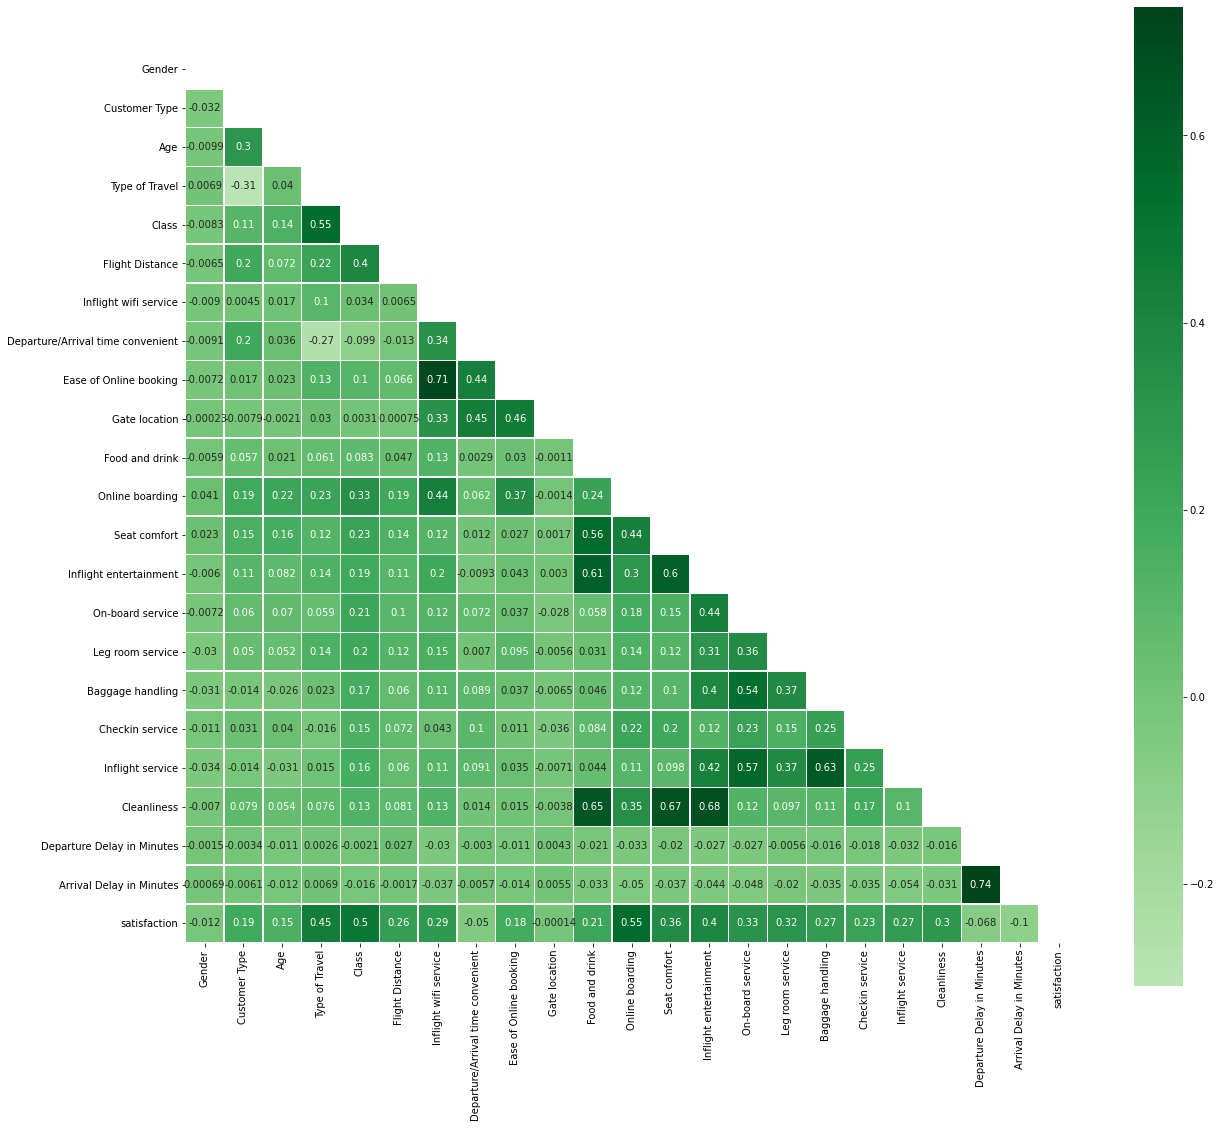

In [8]:
corr = train.corr(method='spearman')
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 18))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot = True, mask=mask, cmap="Greens", center=0,
            square=True, linewidths=.5)

In [9]:
def run_model(model, X_train, y_train, X_test, y_test, verbose=True):
    if verbose == False:
        model.fit(X_train,y_train, verbose=0)
    else:
        model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    roc_auc = roc_auc_score(y_test, y_pred)
    print("ROC_AUC = {}".format(roc_auc))
    print(classification_report(y_test,y_pred,digits=5))
    plot_confusion_matrix(model, X_test, y_test,cmap=plt.cm.Blues, normalize = 'all')
    
    return model, roc_auc

ROC_AUC = 0.9607290873474874
              precision    recall  f1-score   support

           0    0.95556   0.97969   0.96747     14573
           1    0.97318   0.94177   0.95722     11403

    accuracy                        0.96304     25976
   macro avg    0.96437   0.96073   0.96234     25976
weighted avg    0.96329   0.96304   0.96297     25976



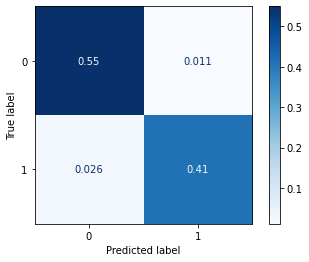

In [10]:
params_rf = {'max_depth': 25,
         'min_samples_leaf': 1,
         'min_samples_split': 2,
         'n_estimators': 1200,
         'random_state': 42}

model_rf = RandomForestClassifier(**params_rf)
model_rf, roc_auc_rf = run_model(model_rf, X_train, y_train, X_test, y_test)

ROC_AUC = 0.9626525730241335
              precision    recall  f1-score   support

           0    0.95747   0.98099   0.96909     14573
           1    0.97492   0.94431   0.95937     11403

    accuracy                        0.96489     25976
   macro avg    0.96620   0.96265   0.96423     25976
weighted avg    0.96513   0.96489   0.96482     25976



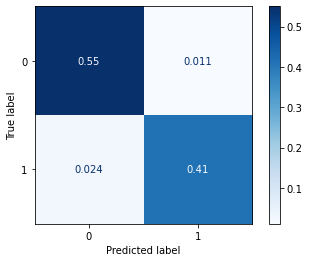

In [12]:
params_lgb ={'colsample_bytree': 0.85, 
             'max_depth': 15, 
             'min_split_gain': 0.1, 
             'n_estimators': 200, 
             'num_leaves': 50, 
             'reg_alpha': 1.2, 
             'reg_lambda': 1.2, 
             'subsample': 0.95, 
             'subsample_freq': 20}

model_lgb = lgb.LGBMClassifier(**params_lgb)
model_lgb, roc_auc_lgb = run_model(model_lgb, X_train, y_train, X_test, y_test)

ROC_AUC = 0.9627442469567447
              precision    recall  f1-score   support

           0    0.95894   0.97907   0.96890     14573
           1    0.97252   0.94642   0.95929     11403

    accuracy                        0.96474     25976
   macro avg    0.96573   0.96274   0.96409     25976
weighted avg    0.96490   0.96474   0.96468     25976



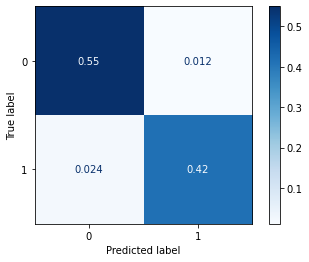

In [13]:
params_cb ={}

model_cb = cb.CatBoostClassifier(**params_cb)
model_cb, roc_auc_cb = run_model(model_cb, X_train, y_train, X_test, y_test, verbose=False)

ROC_AUC = 0.9613126285764666
              precision    recall  f1-score   support

           0    0.95778   0.97770   0.96764     14573
           1    0.97072   0.94493   0.95765     11403

    accuracy                        0.96331     25976
   macro avg    0.96425   0.96131   0.96264     25976
weighted avg    0.96346   0.96331   0.96325     25976



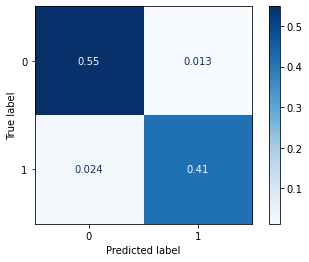

In [14]:
params_xgb ={}

model_xgb = xgb.XGBClassifier(**params_xgb)
model_xgb, roc_auc_xgb = run_model(model_xgb, X_train, y_train, X_test, y_test)

In [15]:
auc_scores = [roc_auc_rf, roc_auc_lgb, roc_auc_cb, roc_auc_xgb]
model_scores = pd.DataFrame(auc_scores, index=['Random Forest','LightGBM','Catboost','XGBoost'], columns=['AUC'])
model_scores.head()

,AUC
Random Forest,0.960729
LightGBM,0.962653
Catboost,0.962744
XGBoost,0.961313
